# 深层神经网络

前一节简要介绍了PyTorch的神经网络实现，同时示范了如何用神经网络构建一个复杂的非线性二分类器。针对图像分类的问题，下面用深度学习的入门级数据集 MNIST 手写体分类来说明深层神经网络的优良表现。


## 1. MNIST 数据集

MNIS数据集是一个非常出名的数据集，基本上很多网络都将其作为一个测试的标准，其来自美国国家标准与技术研究所, National Institute of Standards and Technology (NIST)。 训练集 (training set) 由来自 250 个不同人手写的数字构成, 其中 50% 是高中学生, 50% 来自人口普查局 (the Census Bureau) 的工作人员，一共有 60000 张图片。 测试集(test set) 也是同样比例的手写数字数据，一共有 10000 张图片。

每张图片大小是 28 x 28 的灰度图，如下

![MNIS](imgs/MNIST.jpeg)

任务就是给出一张图片，希望区别出其到底属于 0 到 9 这 10 个数字中的哪一个。


## 2. 多分类问题

前面讲过二分类问题，现在处理的问题更加复杂，是一个 10 分类问题，统称为多分类问题，对于多分类问题， loss 函数使用一个更加复杂的函数，叫交叉熵。

### 2.1 softmax
提到交叉熵，先讲一下 softmax 函数，前面我们见过了 sigmoid 函数，如下

$$s(x) = \frac{1}{1 + e^{-x}}$$

可以将任何一个值转换到 0 ~ 1 之间，当然对于一个二分类问题，这样就足够了，因为对于二分类问题，如果不属于第一类，那么必定属于第二类，所以只需要用一个值来表示其属于其中一类概率，但是对于多分类问题，这样并不行，需要知道其属于每一类的概率，这个时候就需要 softmax 函数了。

softmax 函数示例如下

![softmax](imgs/softmax.jpeg)

对于网络的输出 $z_1, z_2, \cdots z_k$，我们首先对他们每个都取指数变成 $e^{z_1}, e^{z_2}, \cdots, e^{z_k}$，那么每一项都除以他们的求和，也就是

$$
z_i \rightarrow \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}
$$

如果对经过 softmax 函数的所有项求和就等于 1，所以他们每一项都分别表示属于其中某一类的概率。

### 2.2 交叉熵

交叉熵衡量两个分布相似性的一种度量方式，前面讲的二分类问题的 loss 函数就是交叉熵的一种特殊情况，交叉熵的一般公式为

$$
cross\_entropy(p, q) = E_{p}[-\log q] = - \frac{1}{m} \sum_{x} p(x) \log q(x)
$$

对于二分类问题我们可以写成

$$
-\frac{1}{m} \sum_{i=1}^m (y^{i} \log sigmoid(x^{i}) + (1 - y^{i}) \log (1 - sigmoid(x^{i}))
$$


### 2.3 示例程序

In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据

from torch import nn
from torch.autograd import Variable

In [2]:
# 使用内置函数下载 mnist 数据集
train_set = mnist.MNIST('../data/mnist', train=True,  download=True)
test_set  = mnist.MNIST('../data/mnist', train=False, download=True)

我们可以看看其中的一个数据是什么样子的

In [3]:
a_data, a_label = train_set[0]

In [4]:
a_data

In [5]:
a_label

5

这里的读入的数据是 PIL 库中的格式，我们可以非常方便地将其转换为 numpy array

In [6]:
a_data = np.array(a_data, dtype='float32')
print(a_data.shape)

(28, 28)


这里我们可以看到这种图片的大小是 28 x 28

In [7]:
print(a_data)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

我们可以将数组展示出来，里面的 0 就表示黑色，255 表示白色

对于神经网络，我们第一层的输入就是 28 x 28 = 784，所以必须将得到的数据我们做一个变换，使用 reshape 将他们拉平成一个一维向量

In [8]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平成一维向量
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('../data/mnist', train=True,  transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set  = mnist.MNIST('../data/mnist', train=False, transform=data_tf, download=True)

In [9]:
a, a_label = train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
5


In [10]:
from torch.utils.data import DataLoader

# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器
train_data = DataLoader(train_set, batch_size=64,  shuffle=True)
test_data  = DataLoader(test_set,  batch_size=128, shuffle=False)

使用这样的数据迭代器是非常有必要的，如果数据量太大，就无法一次将它们全部读入内存，所以需要使用 Python 迭代器，每次生成一个批次的数据

In [11]:
a, a_label = next(iter(train_data))

In [12]:
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


In [13]:
# 使用 Sequential 定义 4 层神经网络
net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

In [14]:
net

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)

交叉熵在 pytorch 中已经内置了，交叉熵的数值稳定性更差，所以内置的函数已经帮我们解决了这个问题

In [15]:
# 定义 loss 函数
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1

In [16]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()  # 进入训练模式
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 记录误差
        train_loss += loss.item()
        
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = float((pred == label).sum().item())
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        
        out = net(im)
        loss = criterion(out, label)
        
        # 记录误差
        eval_loss += loss.item()
        
        # 记录准确率
        _, pred = out.max(1)
        num_correct = float((pred == label).sum().item())
        acc = num_correct / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.506378, Train Acc: 0.836221, Eval Loss: 0.226694, Eval Acc: 0.926622
epoch: 1, Train Loss: 0.164987, Train Acc: 0.948344, Eval Loss: 0.184498, Eval Acc: 0.944225
epoch: 2, Train Loss: 0.116488, Train Acc: 0.964252, Eval Loss: 0.091890, Eval Acc: 0.972013
epoch: 3, Train Loss: 0.091878, Train Acc: 0.971415, Eval Loss: 0.103008, Eval Acc: 0.968058
epoch: 4, Train Loss: 0.077213, Train Acc: 0.975247, Eval Loss: 0.077611, Eval Acc: 0.975079
epoch: 5, Train Loss: 0.063013, Train Acc: 0.979961, Eval Loss: 0.078302, Eval Acc: 0.976266
epoch: 6, Train Loss: 0.051577, Train Acc: 0.983442, Eval Loss: 0.124061, Eval Acc: 0.961531
epoch: 7, Train Loss: 0.045186, Train Acc: 0.985558, Eval Loss: 0.090560, Eval Acc: 0.972607
epoch: 8, Train Loss: 0.038940, Train Acc: 0.986874, Eval Loss: 0.080782, Eval Acc: 0.976661
epoch: 9, Train Loss: 0.034728, Train Acc: 0.988539, Eval Loss: 0.092462, Eval Acc: 0.974387
epoch: 10, Train Loss: 0.026991, Train Acc: 0.991255, Eval Loss: 0.381

画出 loss 曲线和 准确率曲线

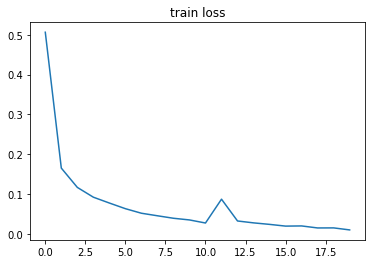

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)

Text(0.5, 1.0, 'train acc')

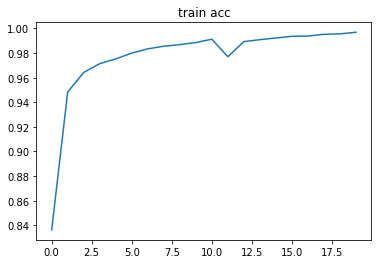

In [18]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')

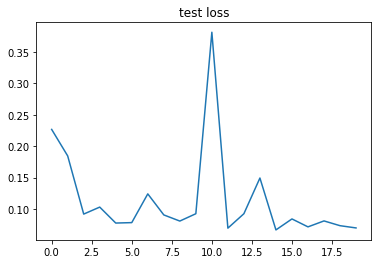

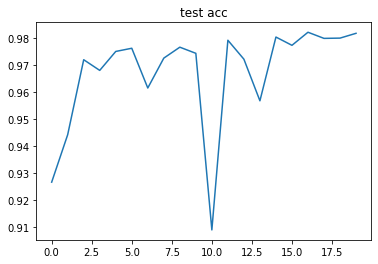

In [19]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')
plt.show()

plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')
plt.show()


## 练习

* 看一看上面的训练过程，看一下准确率是怎么计算出来的，特别注意 max 这个函数
* 自己重新实现一个新的网络，试试改变隐藏层的数目和激活函数，看看有什么新的结果

## 参考
* [损失函数：交叉熵详解](https://zhuanlan.zhihu.com/p/115277553)